# Project : Twitter Data Analysis


## Project Purpose    
 
The goal of this project is to analyze structured problems using Python and Jupyter Notebook, applying concepts of problem-solving, data analysis, and implementation. By working through these exercises, I aim to develop a deeper understanding of how to translate theoretical concepts into practical solutions.

This project allows me to explore a range of problem-solving strategies, test my Python coding skills, and validate results through computation. My objective is to approach each task with an unbiased perspective, ensuring accuracy, clarity, and reproducibility of the outcomes.

I hope this project is both engaging and insightful, as it demonstrates my ability to work independently, analyze given data, and provide meaningful interpretations. The methods and results here reflect a focus on learning and improving technical skills.

DISCLAIMER: This project is purely for educational purposes and is not meant to convey any external views or analyses beyond the scope of the tasks. As a data scientist, my goal is to perform independent analysis objectively and to present insights without any bias.

## Set up
Let us get all the libaries initialized as necessary

In [ ]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import json

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

## Downloading Recent Tweets
It is important to download the most recent tweets. You cannot download the recent tweets by @realdonaldtrump as he was inactive for last two years. But you can download tweets from @elonmusk or @joebiden to see how things work. Those who are working by themselves are allowed to use the downloaded files in data folder w/o setting up access to any twitter API (which can sometime be bit complicated). Twitter provides the API Tweepy (http://www.tweepy.org/) that makes it easy to access twitter content that is publicly available. We will also provide example code as needed.

In [ ]:
## Make sure you have set up tweepy if you are working locally.
# https://www.pythoncentral.io/introduction-to-tweepy-twitter-for-python/
# After set up, the following should run:
import tweepy

## WARNING (Please Read) !!!!


### Protect your Twitter Keys
<span style="color:red">
If someone has your authentication keys, they can access your Twitter account and post as you!  So don't give them to anyone, and **don't write them down in this notebook**. 
</span>
The usual way to store sensitive information like this is to put it in a separate file and read it programmatically.  That way, you can share the rest of your code without sharing your keys.  That's why we're asking you to put your keys in `keys.json` for this assignment.


### Avoid making too many API calls.

<span style="color:red">
Twitter limits developers to a certain rate of requests for data.  If you make too many requests in a short period of time, you'll have to wait awhile (around 15 minutes) before you can make more.  </span> 
So carefully follow the code examples you see and don't rerun cells without thinking.  Instead, always save the data you've collected to a file.  We've provided templates to help you do that.


### Be careful about which functions you call!

<span style="color:red">
This API can retweet tweets, follow and unfollow people, and modify your twitter settings.  Be careful which functions you invoke! </span> It is possible that you can accidentally re-tweet some tweets because you typed `retweet` instead of `retweet_count`. 
</span>


### Reading Keys.json

In [ ]:
import json
key_file = 'keys.json'
# Loading your keys from keys.json (which you should have filled in question 1):
with open(key_file) as f:
    keys = json.load(f)
# if you print or view the contents of keys be sure to delete the cell!

## Working with Twitter Data
The json file in data folder contains some loaded tweets from @RutgersU and @realdonaldtrump. Run the folllowing code and read and understand and what it does. Groups must download the latest tweets from @RutgersU using tweepy (and call that). Individuals can use the given file.

In [1]:
from pathlib import Path
import json

ds_tweets_save_path = "/srv/shared/RutgersU_recent_tweets.json"

# Guarding against attempts to download the data multiple times:
if not Path(ds_tweets_save_path).is_file():
    # Getting as many recent tweets by @RutgersU as Twitter will let us have.
    # We use tweet_mode='extended' so that Twitter gives us full 280 character tweets.
    # This was a change introduced in September 2017.
    
    # The tweepy Cursor API actually returns "sophisticated" Status objects but we 
    # will use the basic Python dictionaries stored in the _json field. 
    example_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, screen_name="RutgersU", tweet_mode='extended').items()]
    
    # Saving the tweets to a JSON file on disk for future analysis
    with open(ds_tweets_save_path, "w") as f:        
        json.dump(example_tweets, f)

# Re-loading the JSON file:
with open(ds_tweets_save_path, "r") as f:
    example_tweets = json.load(f)

### First 10 Tweets

If things ran as expected, you should be able to look at the first tweet by running the code below. It probabably does not make sense to view all tweets in a notebook, as size of the tweets can freeze your browser (always a good idea to press ctrl-S to save the latest, in case you have to restart Jupyter)

In [2]:
# Looking at one tweet object, which has type Status: 
from pprint import pprint # ...to get a more easily-readable view.
text = example_tweets[0].get("full_text", "")
pprint(text)

("RT @RutgersNB: As the #internet turns 50, @RutgersCommInfo's @MaryChayko "
 'focuses on how we have used the innovation and what it has meant f…')


In [3]:
# print the first 50 tweets from the cached file
from pprint import pprint
with open(ds_tweets_save_path, "r") as f:
    example_tweets = json.load(f)

# Assuming example_tweets is a list containing tweet objects
unique_tweets = set()
count = 0
for tweet in example_tweets:
    text = tweet.get("full_text", "")
    if text not in unique_tweets:
        count += 1
        unique_tweets.add(text)
        print(f"Tweet {count}: {text}\n")
        if count == 50:
            break

Tweet 1: RT @RutgersNB: As the #internet turns 50, @RutgersCommInfo's @MaryChayko focuses on how we have used the innovation and what it has meant f…

Tweet 2: RT @RutgersNB: According to U.S. Rep. @FrankPallone, "continuous pharmaceutical manufacturing is the future of medicine." Now, new legislat…

Tweet 3: RT @RutgersLaw: The 34th Annual Mary Philbrook Public Interest Award Celebration honored Lloyd Freeman RLAW'07 (@Esquire1911), Partner and…

Tweet 4: RT @prccrutgers: We will be holding our 4th Annual MLK Oratorical Competition in January 2020. You must write &amp; recite an original speech c…

Tweet 5: Happy first day of November! Can you believe we are already more than halfway through the semester? 🍂

📷: @curtiswebsterr on Instagram https://t.co/8tOBOjvVzl

Tweet 6: RT @RUFedRelations: @EnergyCommerce @FrankPallone @ContinuousMFG @RutgersU To learn more about @FrankPallone's new pharmaceutical manufactu…

Tweet 7: Daniel Hayden went back to school to pursue a physics degree and

### Processing Tweets
To be consistent we are going to use the same dataset no matter what you get from your twitter api. So from this point on, if you are working as a group or individually, be sure to use the data sets provided to you in the srv/shared" folder. One of the files is 'TrumpTweets_1.json', the other one is 'TrumpTweets_2.json'. First load TrumpTweets_1.

In [4]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets will be saved.

    Returns:
        list: A list of Dictionary objects, each representing one tweet."""
    
    with open(path, "rb") as f:
        import json
        return json.load(f)

In [5]:
dest_path = "/srv/shared/TrumpTweets_1.json"
trump_tweets = load_tweets(dest_path)

In [6]:
# print the first 10 Trump tweets
from pprint import pprint
for i, tweet in enumerate(trump_tweets[:10]):
    text = tweet.get("full_text", "")
    print(f"Trump Tweet {i + 1}: {text}\n")

Trump Tweet 1: REGISTER TO https://t.co/0pWiwCHGbh! #MAGA🇺🇸 https://t.co/ACTMe53TZU

Trump Tweet 2: RT @WhiteHouse: https://t.co/RNqLpOtS3O

Trump Tweet 3: Is it really possible that Bruce Ohr, whose wife Nellie was paid by Simpson and GPS Fusion for work done on the Fake Dossier, and who was used as a Pawn in this whole SCAM (WITCH HUNT), is still working for the Department of Justice????? Can this really be so?????

Trump Tweet 4: “Conflict between Glen Simpson’s testimony to another House Panel about his contact with Justice Department official Bruce Ohr. Ohr was used by Simpson and Steele as a Back Channel to get (FAKE) Dossier to FBI. Simpson pleading Fifth.” Catherine Herridge. Where is Jeff Sessions?

Trump Tweet 5: “Federal Judge throws out Stormy Danials lawsuit versus Trump. Trump is entitled to full legal fees.” @FoxNews Great, now I can go after Horseface and her 3rd rate lawyer in the Great State of Texas. She will confirm the letter she signed! She knows nothing about me,

In [7]:
dest_path_2 = "/srv/shared/TrumpTweets_2.json"
trump_tweets_2 = load_tweets(dest_path_2)

In [8]:
# Print the details of the first 10 Trump tweets from 'TrumpTweets_2.json'
for i in range(min(10, len(trump_tweets_2))):
    text2 = trump_tweets_2[i].get("full_text", "")
    print(f"\nTrump Tweet {i + 1} from 'TrumpTweets_2.json':")
    pprint(text2)


Trump Tweet 1 from 'TrumpTweets_2.json':
'Thank you @marklevinshow!\nhttps://t.co/dwQR11genG'

Trump Tweet 2 from 'TrumpTweets_2.json':
'@TeamCavuto  It was a 3 day train ride to Vietnam, not 3 hours!'

Trump Tweet 3 from 'TrumpTweets_2.json':
('RT @realDonaldTrump: 93% Approval Rating in the Republican Party. 52% '
 'Approval Rating overall! Not bad considering I get the most unfair (B…')

Trump Tweet 4 from 'TrumpTweets_2.json':
('RT @realDonaldTrump: I hope our great Republican Senators don’t get led down '
 'the path of weak and ineffective Border Security. Without stro…')

Trump Tweet 5 from 'TrumpTweets_2.json':
('RT @realDonaldTrump: Since my election as President the Dow Jones is up 43% '
 'and the NASDAQ Composite almost 50%. Great news for your 401(k)…')

Trump Tweet 6 from 'TrumpTweets_2.json':
('RT @dcexaminer: Pence says President Trump has "no higher priority than the '
 'safety of the American people." #CPAC2019 https://t.co/fmBGjTBC…')

Trump Tweet 7 from 'TrumpTweets_

### Oldest Tweet

Find the number of the month of the oldest tweet.

In [ ]:
import pandas as pd
import calendar

# Find the number of the month of the oldest tweet (e.g. 1 for January)
df = pd.DataFrame(trump_tweets)

### BEGIN ANSWER
def oldest_tweet(df):
    df['created_at'] = pd.to_datetime(df['created_at'])
    oldest_index = df['created_at'].idxmin()
    oldest_tweet = df.loc[oldest_index]
    return oldest_tweet['created_at'].month
### END ANSWER

oldest_month = oldest_tweet(df)
month_name = calendar.month_name[oldest_month]
print(f"The oldest tweet was created in {oldest_month} also know as {month_name}.")

The oldest tweet was created in 10 also know as October.


## Twitter Source Analysis



### Merging dataframes

Merge the two dataframes created from TrumpTweets_1 and TrumpTweets_2. Call this new dataframe all_tweets

In [10]:
import pandas as pd

### BEGIN ANSWER
trump_tweets_1 = pd.DataFrame(load_tweets("/srv/shared/TrumpTweets_1.json"))
trump_tweets_2 = pd.DataFrame(load_tweets("/srv/shared/TrumpTweets_2.json"))
trump_tweets_3 = pd.DataFrame(load_tweets("/srv/shared/TrumpTweets_3.json"))

all_tweets = pd.concat([trump_tweets_1, trump_tweets_2, trump_tweets_3], ignore_index=True)
all_tweets = all_tweets.reset_index(drop = True)
all_tweets
### END ANSWER

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,retweeted_status,text,is_retweet
0,Tue Oct 16 16:22:11 +0000 2018,1052233253040640001,1052233253040640001,REGISTER TO https://t.co/0pWiwCHGbh! #MAGA🇺🇸 h...,False,"[0, 44]","{'hashtags': [{'text': 'MAGA', 'indices': [37,...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,5415,16565,False,False,False,en,NaN,NaN,NaN,NaN
1,Tue Oct 16 16:18:08 +0000 2018,1052232230972678145,1052232230972678145,RT @WhiteHouse: https://t.co/RNqLpOtS3O,False,"[0, 39]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,4478,0,False,False,False,und,"{'media': [{'id': 1052215563894763522, 'id_str...",{'created_at': 'Tue Oct 16 15:14:16 +0000 2018...,NaN,NaN
2,Tue Oct 16 15:26:33 +0000 2018,1052219253384994816,1052219253384994816,"Is it really possible that Bruce Ohr, whose wi...",False,"[0, 264]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,13103,41253,False,False,NaN,en,NaN,NaN,NaN,NaN
3,Tue Oct 16 15:18:51 +0000 2018,1052217314463100928,1052217314463100928,“Conflict between Glen Simpson’s testimony to ...,False,"[0, 279]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",1.052184e+18,1052184484941049857,...,6271,20251,False,False,NaN,en,NaN,NaN,NaN,NaN
4,Tue Oct 16 15:04:32 +0000 2018,1052213711295930368,1052213711295930368,“Federal Judge throws out Stormy Danials lawsu...,False,"[0, 280]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,14594,54635,False,False,NaN,en,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13243,Fri Jan 01 06:08:06 +0000 2016,682805477168779264,NaN,NaN,NaN,NaN,NaN,Twitter for Android,NaN,NaN,...,2721,7490,NaN,NaN,NaN,NaN,NaN,NaN,"""@jallenaip: Hillary said she was in a ""Fog of...",False
13244,Fri Jan 01 06:07:28 +0000 2016,682805320217980929,NaN,NaN,NaN,NaN,NaN,Twitter for iPhone,NaN,NaN,...,1948,8258,NaN,NaN,NaN,NaN,NaN,NaN,Happy New Year from #MarALago! Thank you to my...,False
13245,Fri Jan 01 05:18:23 +0000 2016,682792967736848385,NaN,NaN,NaN,NaN,NaN,Twitter for iPhone,NaN,NaN,...,3434,9143,NaN,NaN,NaN,NaN,NaN,NaN,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,False
13246,Fri Jan 01 03:25:27 +0000 2016,682764544402440192,NaN,NaN,NaN,NaN,NaN,Twitter for iPhone,NaN,NaN,...,3460,8581,NaN,NaN,NaN,NaN,NaN,NaN,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,False


### Tweet Times
Construct a DataFrame called `df_trump` containing all the tweets stored in `all_tweets`. 
**Important:** There may/will be some overlap so be sure to __eliminate duplicate tweets__. If you do not eliminate the duplicates properly, your results might not be compatible with the test solution. **Hint:** the `id` of a tweet is always unique.

The index of the dataframe should be the ID of each tweet (looks something like `907698529606541312`). It should have these columns:

- `time`: The time the tweet was created encoded as a datetime object. (Use `pd.to_datetime` to encode the timestamp.)
- `source`: The source device of the tweet.
- `text`: The text of the tweet.
- `retweet_count`: The retweet count of the tweet.
- `favorite_count`: The favorite count of the tweet.

Finally, **the resulting dataframe should be sorted by date/time.**

**Warning:** *Some tweets may store the text in the `text` field and other will use the `full_text` field.*

In [11]:
# merged dataframe sorted by date/time (earliet tweet first)
import pandas as pd

### BEGIN ANSWER
all_tweets = all_tweets.copy()
all_tweets['id'] = pd.to_numeric(all_tweets['id'], errors='coerce')
all_tweets = all_tweets.drop_duplicates(subset='id')
all_tweets['full_text'].fillna(all_tweets['text'], inplace=True)
df_trump = all_tweets[['id', 'created_at', 'source', 'full_text', 'retweet_count', 'favorite_count']].copy()
df_trump.columns = ['id', 'time', 'source', 'text', 'retweet_count', 'favorite_count']
df_trump['time'] = pd.to_datetime(df_trump['time'])
df_trump.set_index('id', inplace=True)
df_trump.sort_values(by='time', inplace=True)
df_trump
### END ANSWER

,time,source,text,retweet_count,favorite_count
id,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"I will be on @FoxNews live, with members of m...",2108,6735
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,3460,8581
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,3434,9143
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,1948,8258
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of...",2721,7490
...,...,...,...,...,...
1101856883634302976,2019-03-02 14:48:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @realDonaldTrump: Since my election as Pres...,24511,0
1101857408001949696,2019-03-02 14:50:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @realDonaldTrump: I hope our great Republic...,27707,0
1101857665037287425,2019-03-02 14:51:53+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @realDonaldTrump: 93% Approval Rating in th...,34498,0


In the following questions, we are going to find out the charateristics of Trump tweets and the devices used for the tweets.

First let's examine the source field:

In [12]:
df_trump['source'].unique()

array(['Twitter for Android', 'Twitter for iPhone', 'Twitter Web Client',
       'Mobile Web (M5)', 'Instagram', 'Twitter Ads', 'Twitter for iPad',
       'Media Studio', 'TweetDeck', 'Periscope',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>'],
      dtype=object)

### HTML tags

Remove the HTML tags from the source text field. 

**Hint:** Use `df_trump['source'].str.replace` and your favorite regular expression.

In [13]:
import re
### BEGIN ANSWER
df_trump['source'] = df_trump['source'].str.replace(r'<[^>]*>', '', regex=True)
unique_sources = df_trump['source'].unique()
print(unique_sources)
df_trump.head()
### END ANSWER

['Twitter for Android' 'Twitter for iPhone' 'Twitter Web Client'
 'Mobile Web (M5)' 'Instagram' 'Twitter Ads' 'Twitter for iPad'
 'Media Studio' 'TweetDeck' 'Periscope' 'Twitter Media Studio']


,time,source,text,retweet_count,favorite_count
id,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"I will be on @FoxNews live, with members of m...",2108,6735
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,3460,8581
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,3434,9143
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,1948,8258
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of...",2721,7490


#### Question. What is the most common device used for Trump tweets? Make a plot to find out the most common device types used 
Sort the plot in decreasing order of the most common device type

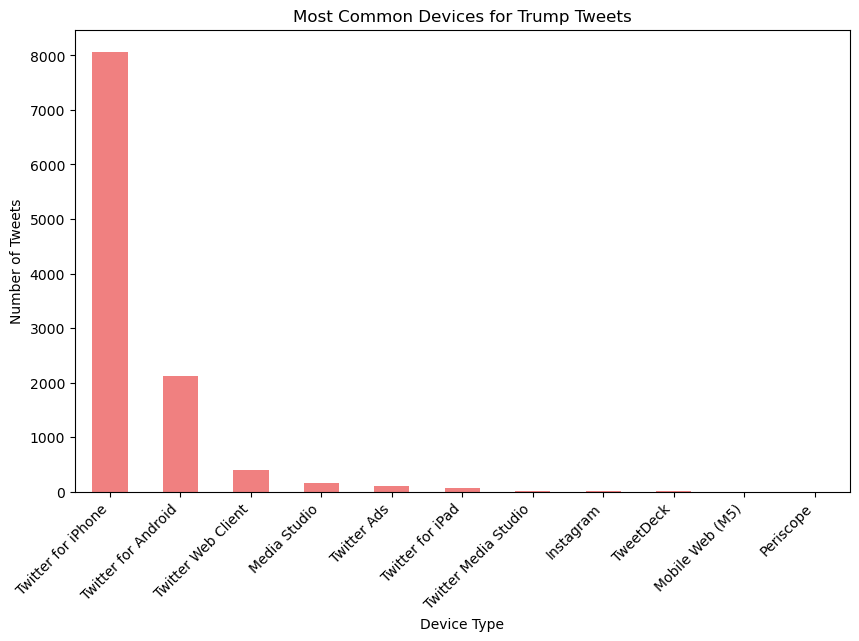

In [14]:
import matplotlib.pyplot as plt
### BEGIN ANSWER
device_counts = df_trump['source'].value_counts()
sorted_device_counts = device_counts.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sorted_device_counts.plot(kind='bar', color='lightcoral')
plt.title('Most Common Devices for Trump Tweets')
plt.xlabel('Device Type')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45, ha='right')
plt.show()
### END ANSWER

### Devices
Is there a difference between his Tweet behavior across these devices? We will attempt to answer this question in our subsequent analysis.

First, we'll take a look at whether Trump's tweets from an Android come at different times than his tweets from an iPhone. Note that Twitter gives us his tweets in the [UTC timezone](https://www.wikiwand.com/en/List_of_UTC_time_offsets) (notice the `+0000` in the first few tweets)

**Note** - If your `time` column is not in datetime format, the following code will not work.

In [15]:
df_trump['time'][0:3]

id
682723973449289728   2016-01-01 00:44:14+00:00
682764544402440192   2016-01-01 03:25:27+00:00
682792967736848385   2016-01-01 05:18:23+00:00
Name: time, dtype: datetime64[ns, UTC]

We'll convert the tweet times to US Eastern Time, the timezone of New York and Washington D.C., since those are the places we would expect the most tweet activity from Trump.

In [16]:
df_trump['est_time'] = (
    df_trump['time'] # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
df_trump.head()

,time,source,text,retweet_count,favorite_count,est_time
id,,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"I will be on @FoxNews live, with members of m...",2108,6735,2015-12-31 19:44:14-05:00
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,3460,8581,2015-12-31 22:25:27-05:00
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,3434,9143,2016-01-01 00:18:23-05:00
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,1948,8258,2016-01-01 01:07:28-05:00
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of...",2721,7490,2016-01-01 01:08:06-05:00


**What we need to do:**

Add a column called `hour` to the `df_trump` table which contains the hour of the day as floating point number computed by:

$$
\text{hour} + \frac{\text{minute}}{60} + \frac{\text{second}}{60^2}
$$

In [17]:
df_trump['hour'] = (df_trump['est_time'].dt.hour) + (df_trump['est_time'].dt.minute/60) + (df_trump['est_time'].dt.second/3600)
# a new column that contains the rounded hour
df_trump['roundhour']=round(df_trump['hour'])
df_trump.head()

,time,source,text,retweet_count,favorite_count,est_time,hour,roundhour
id,,,,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"I will be on @FoxNews live, with members of m...",2108,6735,2015-12-31 19:44:14-05:00,19.737222,20.0
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,3460,8581,2015-12-31 22:25:27-05:00,22.424167,22.0
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,3434,9143,2016-01-01 00:18:23-05:00,0.306389,0.0
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,1948,8258,2016-01-01 01:07:28-05:00,1.124444,1.0
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of...",2721,7490,2016-01-01 01:08:06-05:00,1.135000,1.0


Use the `roundhour` column and plot the number of tweets at every hour of the day.
Order the plot using the hour of the day (1 to 24). Use seaborn `countplot`

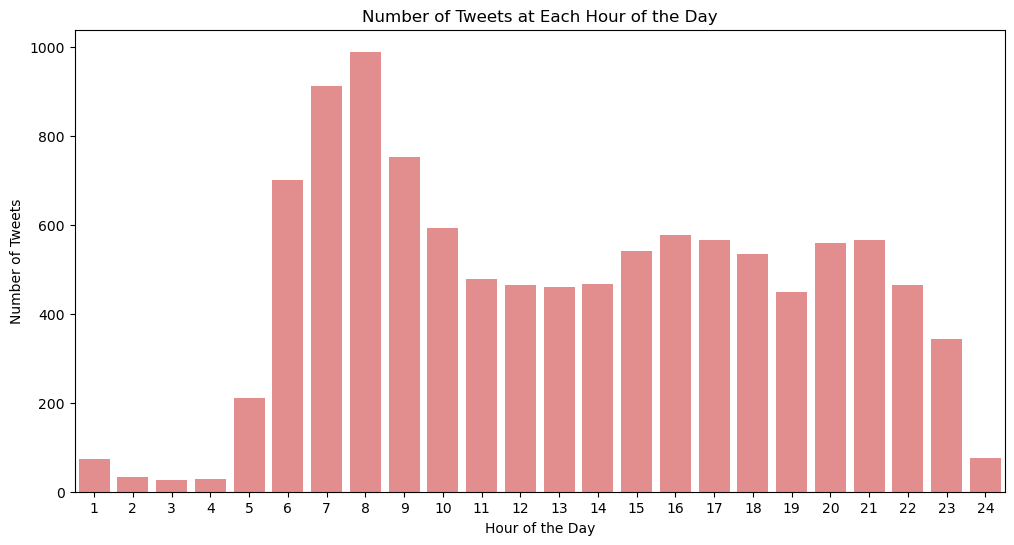

In [18]:
# make a bar plot here
import seaborn as sns
import matplotlib.pyplot as plt
### BEGIN ANSWER
df_trump['roundhour'] = df_trump['roundhour'].astype(int)

plt.figure(figsize=(12, 6))
sns.countplot(x='roundhour', data=df_trump, order=range(1, 25), color='lightcoral')
plt.title('Number of Tweets at Each Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Tweets')
plt.show()
### END ANSWER

Now, use this data along with the seaborn `distplot` function to examine the distribution over hours of the day in eastern time that trump tweets on each device for the 2 most commonly used devices.


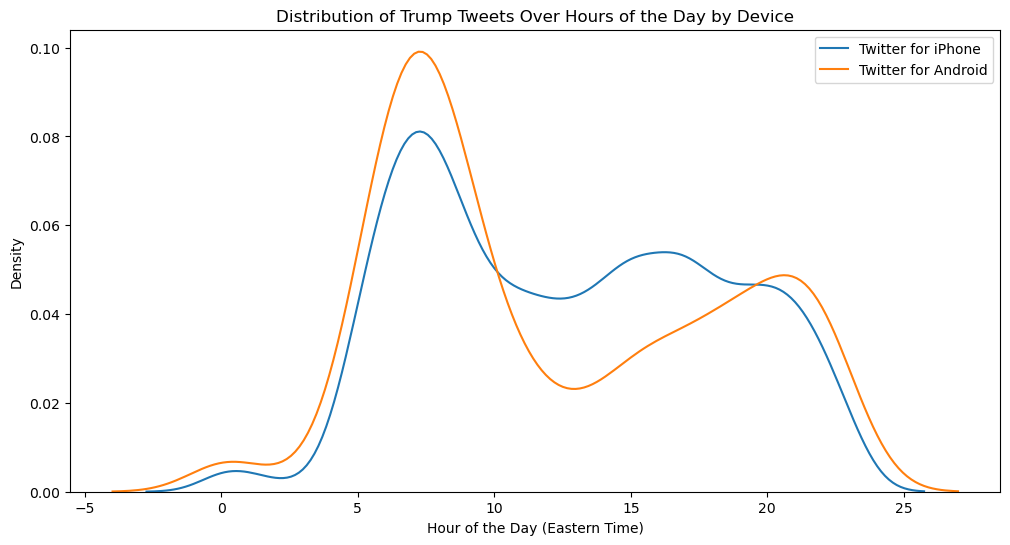

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
### BEGIN ANSWER
common_devices = df_trump['source'].value_counts().nlargest(2).index
df_common_devices = df_trump[df_trump['source'].isin(common_devices)]

plt.figure(figsize=(12, 6))
#sns.histplot(df_common_devices[df_common_devices['source'] == common_devices[0]]['roundhour'], label=common_devices[0], kde = True, stat = 'density', common_norm = False)
#sns.histplot(df_common_devices[df_common_devices['source'] == common_devices[1]]['roundhour'], label=common_devices[1], kde = True, stat = 'density', common_norm = False)
sns.kdeplot(df_common_devices[df_common_devices['source'] == common_devices[0]]['est_time'].dt.hour, label=common_devices[0])
sns.kdeplot(df_common_devices[df_common_devices['source'] == common_devices[1]]['est_time'].dt.hour, label=common_devices[1])

plt.xlabel('Hour of the Day (Eastern Time)')
plt.ylabel('Density')
plt.title('Distribution of Trump Tweets Over Hours of the Day by Device')
plt.legend()
plt.show()
### END ANSWER

### iPhone or Android

According to [this Verge article](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android), Donald Trump switched from an Android to an iPhone sometime in March 2017.

Create a figure identical to our figure, except that we should show the results only from 2016. If we get stuck consider looking at the `year_fraction` function from the next problem.

Use this data along with the seaborn `distplot` function to examine the distribution over hours of the day in eastern time that trump tweets on each device for the 2 most commonly used devices. Our plot should look somewhat similar to the following. 

During the campaign, it was theorized that Donald Trump's tweets from Android were written by him personally, and the tweets from iPhone were from his staff. Does your figure give support the theory?

**Your Response**: 


In 2016, the time allocation for the usage of the iphone centered in the afternoon, while his tweets from 2015 to present shows that he mostly tweets in the morning. It seems that the tweets from iphone in 2016 were from his staff, not himself.

\\
<img src="images/device_hour2.png" align="left" alt="Drawing" style="width: 600px;"/>


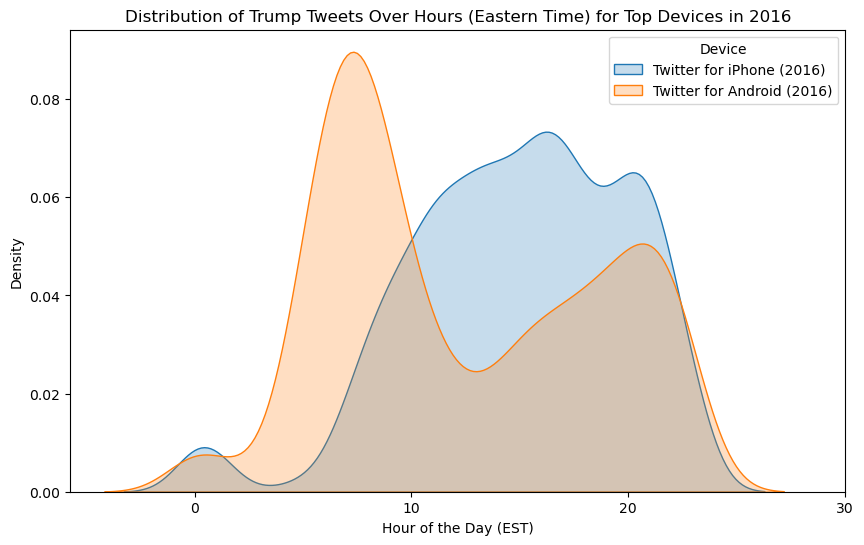

In [20]:
### BEGIN ANSWER
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timezone, timedelta

tweets_2016 = df_trump[df_trump['time'].dt.year == 2016].copy()
top_devices_2016 = tweets_2016['source'].value_counts().head(2).index.tolist()
df_top_devices_2016 = tweets_2016[tweets_2016['source'].isin(top_devices_2016)].copy()
eastern = timezone(timedelta(hours=-5))
df_top_devices_2016['est_time'] = df_top_devices_2016['time'].dt.tz_convert(eastern)

plt.figure(figsize=(10, 6))

sns.kdeplot(df_top_devices_2016[df_top_devices_2016['source'] == top_devices_2016[0]]['est_time'].dt.hour,
             label=f'{top_devices_2016[0]} (2016)', fill=True)
sns.kdeplot(df_top_devices_2016[df_top_devices_2016['source'] == top_devices_2016[1]]['est_time'].dt.hour,
             label=f'{top_devices_2016[1]} (2016)', fill=True)

plt.xticks([0, 10, 20, 30], labels=['0', '10', '20', '30'])
plt.title('Distribution of Trump Tweets Over Hours (Eastern Time) for Top Devices in 2016')
plt.xlabel('Hour of the Day (EST)')
plt.ylabel('Density')
plt.legend(title='Device')
plt.show()
### END ANSWER

### Time of the day
* What time of the day the Android tweets were made by Trump himself? (eg: morning, late night etc). Just speculate based on data

The plot above shows two tweet grows, one of which happens between hours four and ten. Between 20 and 23 there is an additional peak. I believe that between 8 a.m. and 10 p.m., Trump sent the majority of his tweets.

* What time of the day the Android tweets were made by paid staff?

Considering that paid staff were responsible for the android's tweets, the device began tweeting at ten in the morning and continued for over twenty-one hours. Consequently, I believe that paid staff tweeted the most between 11 a.m. and 10 p.m.

### Device Analysis
Let's now look at which device he has used over the entire time period of this dataset.

To examine the distribution of dates we will convert the date to a fractional year that can be plotted as a distribution.

(Code borrowed from https://stackoverflow.com/questions/6451655/python-how-to-convert-datetime-dates-to-decimal-years)

In [21]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length


df_trump['year'] = df_trump['time'].apply(year_fraction) #should be df_trump

Use the `sns.distplot` to overlay the distributions of the 2 most frequently used web technologies over the years.


/tmp/ipykernel_1459075/3556067006.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipykernel_1459075/3556067006.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


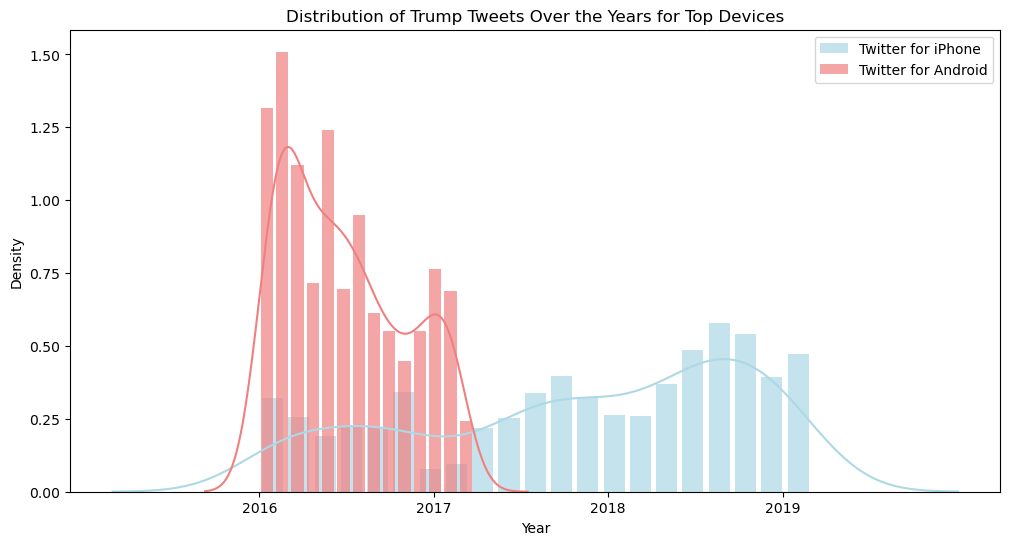

In [54]:
### BEGIN ANSWER
import matplotlib.pyplot as plt
import seaborn as sns

top_web_tech = df_trump['source'].value_counts().index[:2]
web_technology_data = df_trump[df_trump['source'].isin(top_web_tech)]
plt.figure(figsize=(12, 6))

colors = {'Twitter for iPhone': 'lightblue', 'Twitter for Android': 'lightcoral'}

for i, web in enumerate(top_web_tech):
    sns.distplot(
        web_technology_data[web_technology_data['source'] == web]['year'],
        hist=True,
        kde=True,
        label=web,
        color = colors.get(web),
        kde_kws={'bw_method': 0.3},
        hist_kws={'rwidth': 0.8, 'alpha': 0.7} 
    )

plt.xlabel('Year')
plt.yticks([0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50])
plt.title('Distribution of Trump Tweets Over the Years for Top Devices')
plt.xticks([2016, 2017, 2018, 2019])
plt.legend()
plt.show()
### END ANSWER

## Sentiment Analysis

It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [23]:
print(''.join(open("/srv/shared/vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



### Polarities

As you can see, the lexicon contains emojis too! The first column of the lexicon is the *token*, or the word itself. The second column is the *polarity* of the word, or how positive / negative it is.

**Question** How did they decide the polarities of these words? What are the other two columns in the lexicon? (See the link above.)

 Read in the lexicon into a DataFrame called `df_sent`. The index of the DF should be the tokens in the lexicon. `df_sent` should have one column: `polarity`: The polarity of each token.

In [24]:
### BEGIN ANSWER
import pandas as pd
lexicon_file_path = "/srv/shared/vader_lexicon.txt"
df_sent = pd.read_csv(lexicon_file_path, sep='\t', header=None, names=['token', 'polarity', 'std_dev', 'ratings'])
df_sent.set_index('token', inplace=True)
df_sent = df_sent[['polarity']]
df_sent.head()
### END ANSWER

,polarity
token,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


### Sentiment

Now, let's use this lexicon to calculate the overall sentiment for each of Trump's tweets. Here's the basic idea:

1. For each tweet, find the sentiment of each word.
2. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

Be sure to lowercase the text in the tweets since the lexicon is also lowercase. Set the `text` column of the `df_trump` DF to be the lowercased text of each tweet.

In [25]:
!pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable


In [26]:
### BEGIN ANSWER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

df_trump['text'] = df_trump['text'].str.lower().fillna("")
analyzer = SentimentIntensityAnalyzer()

def calculate_sentiment(text):
    if isinstance(text, str):
        sentiment = analyzer.polarity_scores(text)['compound']
        return sentiment
    else:
        return 0
df_trump['sentiment'] = df_trump['text'].apply(calculate_sentiment)
# print(df_trump[['text', 'sentiment']].head())
df_trump
### END ANSWER

,time,source,text,retweet_count,favorite_count,est_time,hour,roundhour,year,sentiment
id,,,,,,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"i will be on @foxnews live, with members of m...",2108,6735,2015-12-31 19:44:14-05:00,19.737222,20,2016.000000,0.6892
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,happy new year &amp; thank you! https://t.co/y...,3460,8581,2015-12-31 22:25:27-05:00,22.424167,22,2016.000000,0.7574
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#happynewyearamerica! https://t.co/eeqb8pdrue,3434,9143,2016-01-01 00:18:23-05:00,0.306389,0,2016.000000,0.0000
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,happy new year from #maralago! thank you to my...,1948,8258,2016-01-01 01:07:28-05:00,1.124444,1,2016.000000,0.9230
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: hillary said she was in a ""fog of...",2721,7490,2016-01-01 01:08:06-05:00,1.135000,1,2016.000000,-0.8478
...,...,...,...,...,...,...,...,...,...,...
1101856883634302976,2019-03-02 14:48:47+00:00,Twitter for iPhone,rt @realdonaldtrump: since my election as pres...,24511,0,2019-03-02 09:48:47-05:00,9.813056,10,2019.164384,0.5888
1101857408001949696,2019-03-02 14:50:52+00:00,Twitter for iPhone,rt @realdonaldtrump: i hope our great republic...,27707,0,2019-03-02 09:50:52-05:00,9.847778,10,2019.164384,0.7184
1101857665037287425,2019-03-02 14:51:53+00:00,Twitter for iPhone,rt @realdonaldtrump: 93% approval rating in th...,34498,0,2019-03-02 09:51:53-05:00,9.864722,10,2019.164384,0.8248


### Punctuations

Now, let's get rid of punctuation since it'll cause us to fail to match words. Create a new column called `no_punc` in the `df_trump` to be the lowercased text of each tweet with all punctuation replaced by a single space. We consider punctuation characters to be any character that isn't a Unicode word character or a whitespace character. You may want to consult the Python documentation on regexes for this problem.


In [27]:
import re
# Save your regex in punct_re
punct_re = r'[^\w\s\\n]'

### BEGIN ANSWER
df_trump['no_punc'] = df_trump['text'].str.replace(punct_re, ' ', regex=True)
# print(df_trump[['text', 'no_punc', 'sentiment']].head())
df_trump
### END ANSWER

,time,source,text,retweet_count,favorite_count,est_time,hour,roundhour,year,sentiment,no_punc
id,,,,,,,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"i will be on @foxnews live, with members of m...",2108,6735,2015-12-31 19:44:14-05:00,19.737222,20,2016.000000,0.6892,i will be on foxnews live with members of m...
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,happy new year &amp; thank you! https://t.co/y...,3460,8581,2015-12-31 22:25:27-05:00,22.424167,22,2016.000000,0.7574,happy new year amp thank you https t co y...
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#happynewyearamerica! https://t.co/eeqb8pdrue,3434,9143,2016-01-01 00:18:23-05:00,0.306389,0,2016.000000,0.0000,happynewyearamerica https t co eeqb8pdrue
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,happy new year from #maralago! thank you to my...,1948,8258,2016-01-01 01:07:28-05:00,1.124444,1,2016.000000,0.9230,happy new year from maralago thank you to my...
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: hillary said she was in a ""fog of...",2721,7490,2016-01-01 01:08:06-05:00,1.135000,1,2016.000000,-0.8478,jallenaip hillary said she was in a fog of...
...,...,...,...,...,...,...,...,...,...,...,...
1101856883634302976,2019-03-02 14:48:47+00:00,Twitter for iPhone,rt @realdonaldtrump: since my election as pres...,24511,0,2019-03-02 09:48:47-05:00,9.813056,10,2019.164384,0.5888,rt realdonaldtrump since my election as pres...
1101857408001949696,2019-03-02 14:50:52+00:00,Twitter for iPhone,rt @realdonaldtrump: i hope our great republic...,27707,0,2019-03-02 09:50:52-05:00,9.847778,10,2019.164384,0.7184,rt realdonaldtrump i hope our great republic...
1101857665037287425,2019-03-02 14:51:53+00:00,Twitter for iPhone,rt @realdonaldtrump: 93% approval rating in th...,34498,0,2019-03-02 09:51:53-05:00,9.864722,10,2019.164384,0.8248,rt realdonaldtrump 93 approval rating in th...


**Question** Why don't we simply remove punctuation instead of replacing with a space? See if you can figure this out by looking at the tweet data.S

Keeping appropriate word spacing in tweets and avoiding unwanted combos can be achieved by using a space for punctuation instead of removing it. By analyzing each word separately during analysis, this method helps to prevent any mistakes in word interpretation.

In [28]:
assert isinstance(punct_re, str)
assert re.search(punct_re, 'this') is None
assert re.search(punct_re, 'this is ok') is None
assert re.search(punct_re, 'this is\nok') is None
assert re.search(punct_re, 'this is not ok.') is not None
assert re.search(punct_re, 'this#is#ok') is not None
assert re.search(punct_re, 'this^is ok') is not None
assert df_trump['no_punc'].loc[800329364986626048] == 'i watched parts of  nbcsnl saturday night live last night  it is a totally one sided  biased show   nothing funny at all  equal time for us '
assert df_trump['text'].loc[884740553040175104] == 'working hard to get the olympics for the united states (l.a.). stay tuned!'


### Tidy Format


Now, let's convert the tweets into what's called a [*tidy format*](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) to make the sentiments easier to calculate. Use the `no_punc` column of `df_trump` to create a table called `tidy_format`. The index of the table should be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

The first few rows of our `tidy_format` table look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>num</th>
      <th>word</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>894661651760377856</th>
      <td>0</td>
      <td>i</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>1</td>
      <td>think</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>2</td>
      <td>senator</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>3</td>
      <td>blumenthal</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>4</td>
      <td>should</td>
    </tr>
  </tbody>
</table>

You can double check that your tweet with ID `894661651760377856` has the same rows as ours. Our tests don't check whether your table looks exactly like ours.

As usual, try to avoid using any for loops. Our solution uses a chain of 5 methods on the 'trump' DF, albeit using some rather advanced Pandas hacking.

* **Hint 1:** Try looking at the `expand` argument to pandas' `str.split`.

* **Hint 2:** Try looking at the `stack()` method.

* **Hint 3:** Try looking at the `level` parameter of the `reset_index` method.

In [29]:
#tidy_format = ...

### BEGIN ANSWER
tidy_format = df_trump['no_punc'].str.split(expand=True).stack().to_frame().reset_index(level = 1)
tidy_format.columns = ["num", "word"]
# print(tidy_format)
tidy_format.head()
### END ANSWER

,num,word
id,,
682723973449289728,0,i
682723973449289728,1,will
682723973449289728,2,be
682723973449289728,3,on
682723973449289728,4,foxnews


In [30]:
assert tidy_format.loc[894661651760377856].shape == (27, 2)
assert ' '.join(list(tidy_format.loc[894661651760377856]['word'])) == 'i think senator blumenthal should take a nice long vacation in vietnam where he lied about his service so he can at least say he was there'

### Polrity Column

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table. 

Add a `polarity` column to the `df_trump` table.  The `polarity` column should contain the sum of the sentiment polarity of each word in the text of the tweet.

**Hint** you will need to merge the `tidy_format` and `df_sent` tables and group the final answer.


In [31]:
#df_trump['polarity'] = ...
import numpy as np
### BEGIN ANSWER
df_trump['polarity'] = (tidy_format.merge(df_sent, left_on = 'word', right_index = True)['polarity'].reset_index().groupby('id').sum())
df_trump['polarity'].replace(np.float64('nan'), 0, inplace = True)
df_trump
### END ANSWER

,time,source,text,retweet_count,favorite_count,est_time,hour,roundhour,year,sentiment,no_punc,polarity
id,,,,,,,,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"i will be on @foxnews live, with members of m...",2108,6735,2015-12-31 19:44:14-05:00,19.737222,20,2016.000000,0.6892,i will be on foxnews live with members of m...,3.1
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,happy new year &amp; thank you! https://t.co/y...,3460,8581,2015-12-31 22:25:27-05:00,22.424167,22,2016.000000,0.7574,happy new year amp thank you https t co y...,4.2
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#happynewyearamerica! https://t.co/eeqb8pdrue,3434,9143,2016-01-01 00:18:23-05:00,0.306389,0,2016.000000,0.0000,happynewyearamerica https t co eeqb8pdrue,0.0
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,happy new year from #maralago! thank you to my...,1948,8258,2016-01-01 01:07:28-05:00,1.124444,1,2016.000000,0.9230,happy new year from maralago thank you to my...,9.0
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: hillary said she was in a ""fog of...",2721,7490,2016-01-01 01:08:06-05:00,1.135000,1,2016.000000,-0.8478,jallenaip hillary said she was in a fog of...,-5.9
...,...,...,...,...,...,...,...,...,...,...,...,...
1101856883634302976,2019-03-02 14:48:47+00:00,Twitter for iPhone,rt @realdonaldtrump: since my election as pres...,24511,0,2019-03-02 09:48:47-05:00,9.813056,10,2019.164384,0.5888,rt realdonaldtrump since my election as pres...,3.1
1101857408001949696,2019-03-02 14:50:52+00:00,Twitter for iPhone,rt @realdonaldtrump: i hope our great republic...,27707,0,2019-03-02 09:50:52-05:00,9.847778,10,2019.164384,0.7184,rt realdonaldtrump i hope our great republic...,4.0
1101857665037287425,2019-03-02 14:51:53+00:00,Twitter for iPhone,rt @realdonaldtrump: 93% approval rating in th...,34498,0,2019-03-02 09:51:53-05:00,9.864722,10,2019.164384,0.8248,rt realdonaldtrump 93 approval rating in th...,1.3


In [32]:
assert np.allclose(df_trump.loc[744701872456536064, 'polarity'], 8.4)
assert np.allclose(df_trump.loc[745304731346702336, 'polarity'], 2.5)
assert np.allclose(df_trump.loc[744519497764184064, 'polarity'], 1.7)
assert np.allclose(df_trump.loc[894661651760377856, 'polarity'], 0.2)
assert np.allclose(df_trump.loc[894620077634592769, 'polarity'], 5.4)
# If you fail this test, you dropped tweets with 0 polarity
#assert np.allclose(df_trump.loc[744355251365511169, 'polarity'], 0.0)


### Most Positive and Negative Tweets
Now we have a measure of the sentiment of each of his tweets! You can read over the VADER readme to understand a more robust sentiment analysis.
Now, write the code to see the 20 most positive and most 20 negative tweets from Trump in your dataset:
Find the most negative and most positive tweets made by Trump

In [33]:
print('Most negative tweets:')

### BEGIN ANSWER
most_negative_tweets = df_trump.sort_values('polarity').head(20)
most_negative_tweets[['text', 'polarity']]
### END ANSWER

Most negative tweets:


,text,polarity
id,,
1084649448003784704,the trump portrait of an unsustainable border ...,-20.4
1031590431379865600,it is outrageous that poisonous synthetic hero...,-20.3
1029731513573822464,the rigged russian witch hunt goes on and on a...,-16.6
1056299897882923009,...this evil anti-semitic attack is an assault...,-16.1
984763579210633216,james comey is a proven leaker &amp; liar. vir...,-16.0
1074319076766433280,"at the request of many, i will be reviewing th...",-15.7
1070314629732163586,.....considered to be the worst and most dange...,-15.4
1027585937163931648,this is an illegally brought rigged witch hunt...,-15.2
1031508193107763200,where’s the collusion? they made up a phony cr...,-15.0


In [34]:
print('Most positive tweets:')

### BEGIN ANSWER
most_positive_tweets = df_trump.sort_values('polarity', ascending=False).head(20)
most_positive_tweets[['text', 'polarity']]
### END ANSWER

Most positive tweets:


,text,polarity
id,,
983143317889323008,congratulations to patrick reed on his great a...,26.5
1082648785312976896,congratulations to a truly great football team...,21.2
1007974129474121728,"my supporters are the smartest, strongest, mos...",20.7
973716838889660416,it was my great honor to deliver a message at ...,18.9
1016638035281219584,"thank you to all of my great supporters, reall...",18.9
1014287566386888709,"thank you, @wvgovernor jim justice, for that w...",18.6
994176238846664706,the republican party had a great night. tremen...,18.5
1068826073775964160,"president george h.w. bush led a long, success...",18.2
819541997325316096,thank you to linda bean of l.l.bean for your g...,18.2


### NYT vs FOX
Plot the distribution of tweet sentiments broken down by whether the text of the tweet contains `nyt` or `fox`.

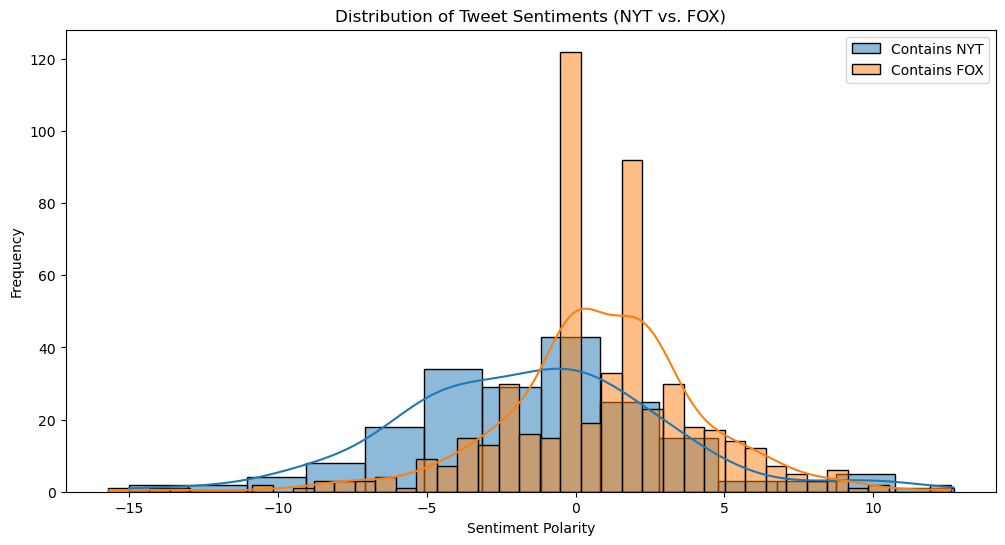

In [35]:
### BEGIN ANSWER
import matplotlib.pyplot as plt
import seaborn as sns

nyt = df_trump[df_trump['text'].str.contains('nyt', case=False, na=False)]
fox = df_trump[df_trump['text'].str.contains('fox', case=False, na=False)]

plt.figure(figsize=(12, 6))
sns.histplot(nyt['polarity'], label='Contains NYT', kde=True)
sns.histplot(fox['polarity'], label='Contains FOX', kde=True)
plt.title('Distribution of Tweet Sentiments (NYT vs. FOX)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()
### END ANSWER

##### Comment on what we observe:

According to the graph above, there are more favorable tweets on Fox than on NYT, maybe because Trump prefers Fox over NYT. Also, we can say its bell shaped symmetric shapes.

## Principal Component Analysis (PCA) and Twitter
A look at the top words used and the sentiments expressed in Trump tweets indicates that, some words are used with others almost all the time. A notable example is the slogan like **Make America Great Again**. As such, it may be beneficial to look at groups of words rather than individual words. For that, we will look at an approach applying a Principal Component Analysis. 

### The PCA
The Principal Component Analysis, or PCA, is a tool generally used to identify patterns and to reduce the number of variables you have to consider in your analysis. For example, if you have data with 200 columns, it may be that a significant amount of the variance in your data can be explained by just 100 principal components. In the PCA, the first component is chosen in such a way that has the largest variance, subsequent components are orthogonal and continue covering as much variance as possible. In this way, the PCA samples as much of the variability in the data set with the first few components. Mathematically, each component is a linear combination of all the input parameters times coefficients specific for that component. These coefficients, or loading factors, are constrained such that the sum of the squares of them are equal to 1. As such, the loading factors serve as weights describing how strongly certain parameters contribute to the specific principal component. Parameters with large values of positive or negative loading factors are correlated with each other, which can serve to identify trends in your data.

### Cleaning up the Data
Using NLTK (Natural Language Toolkit) package for language processing and other python libraries, parse the json file to deal with inflected words, such as plurals, and removed stop words like common English words (the, and, it, etc) and certain political terms (the candidates names, for example). You can start with the top 50 words, but full analysis may require large number of words.
Create a document-frequecy (df) matrix with 5000 rows and 50 columns where each column is a particular word (feature) and each row is a tweet (observation). The values of the matrix is how often the word appears. Apply the techniques we learned to reduce the weight of most common words (if necessary). Since this is a sparse matrix, you can use the sparse martix libraries to make things a bit more efficient (we can also use a regular numpy arrays to store these things since the dimensions are not too large). See demo notes books and lecture slides for some sparse matrix methods.
Print the first 10 rows of the df to show the matrix you created

Start with the `tidy_format` dataframe

In [36]:
### BEGIN ANSWER
## code to plot the first 10 rows of the matrix
import nltk
import nltk.corpus
#nltk.download('stopwords')
#nltk.download('wordnet')

# create a dataframe called tmp to store all words appear in the tweets
data_frame_tmp = tidy_format.drop('num', axis=1)

# remove stopwords
stopwords_list = nltk.corpus.stopwords.words("english")
stopwords_list.extend(['rt','t','co','https','realdonaldtrump','amp',"u",'hillary','trump2016','trump','clinton','http','ha','wa'])
data_frame_tmp = data_frame_tmp[~data_frame_tmp['word'].isin(stopwords_list)]

# deal with plurals
from nltk.stem import WordNetLemmatizer
word_lemmatizer = WordNetLemmatizer()
data_frame_tmp['word'] = data_frame_tmp['word'].apply(lambda x: word_lemmatizer.lemmatize(x))

# Remove numbers
data_frame_tmp = data_frame_tmp[~data_frame_tmp['word'].str.isnumeric()]

# Remove words with only 1 or 2 length
data_frame_tmp = data_frame_tmp[data_frame_tmp['word'].str.len() > 2]

# Get the top 50 words
word_counts = data_frame_tmp['word'].value_counts()
top_50_words = word_counts.head(50)
top_50_words_list = top_50_words.index.tolist()
first_5000_tweets = df_trump['text'].iloc[:5000]
word_to_index = {}
for i in range(len(top_50_words_list)):
    word_to_index[top_50_words_list[i]] = i

print(word_to_index)

document_frequency_matrix = np.zeros((5000, 50))

for i in range(5000):
    if data_frame_tmp.iloc[i]['word'] in top_50_words_list:
        document_frequency_matrix[i, word_to_index[data_frame_tmp.iloc[i]['word']]] += 1

print(document_frequency_matrix[:10])
### END ANSWER

{'great': 0, 'thank': 1, 'people': 2, 'country': 3, 'president': 4, 'america': 5, 'job': 6, 'big': 7, 'get': 8, 'time': 9, 'border': 10, 'state': 11, 'year': 12, 'new': 13, 'today': 14, 'news': 15, 'many': 16, 'make': 17, 'democrat': 18, 'vote': 19, 'american': 20, 'want': 21, 'fake': 22, 'would': 23, 'never': 24, 'much': 25, 'republican': 26, 'one': 27, 'medium': 28, 'tax': 29, 'back': 30, 'good': 31, 'going': 32, 'day': 33, 'must': 34, 'like': 35, 'crooked': 36, 'win': 37, 'bad': 38, 'wall': 39, 'election': 40, 'deal': 41, 'even': 42, 'makeamericagreatagain': 43, 'obama': 44, 'security': 45, 'first': 46, 'united': 47, 'trade': 48, 'look': 49}
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

### Find the PCA's
Write the code to find the first 50 PCA's for the document-frequency matrix. Pass the document-term-matrix to scikit-learn’s (https://scikit-learn.org/stable/modules/decomposition.html#decompositions) PCA method to obtain the components and loading factors.

In [37]:
from sklearn.decomposition import PCA
### BEGIN ANSWER
pca = PCA(n_components=50)
pca.fit(document_frequency_matrix)
principal_components = pca.components_
loading_factors = pca.transform(document_frequency_matrix)
print(principal_components)
print(loading_factors)
### END ANSWER

[[ 9.88579254e-01 -1.46946107e-01 -9.08908355e-03 ... -3.37050119e-04
   0.00000000e+00 -1.87283961e-03]
 [ 1.45178831e-01  9.88121908e-01 -1.30585195e-02 ... -4.49606073e-04
  -0.00000000e+00 -2.53002420e-03]
 [ 2.59338554e-02  3.10802100e-02 -1.91814013e-02 ... -4.19168263e-04
  -0.00000000e+00 -2.51003071e-03]
 ...
 [-0.00000000e+00 -7.95820251e-17  7.25173203e-17 ... -2.77555756e-17
  -0.00000000e+00  5.55111512e-17]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
  -1.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -4.66126870e-18  6.88900112e-17 ...  2.77555756e-17
  -0.00000000e+00 -1.24900090e-16]]
[[-1.34600808e-02 -1.61353065e-02 -1.01608127e-02 ... -1.14828257e-18
   0.00000000e+00 -2.10176418e-18]
 [-1.34600808e-02 -1.61353065e-02 -1.01608127e-02 ... -1.14828257e-18
   0.00000000e+00 -2.10176418e-18]
 [-1.34600808e-02 -1.61353065e-02 -1.01608127e-02 ... -1.14828257e-18
   0.00000000e+00 -2.10176418e-18]
 ...
 [-1.34600808e-02 -1.61353065e-02 -1.0160812

### Examine the PCA
We can examine the PCA results to look at the heatmap. Make a grid plot which shows the various principal component along the x-axis and the individual words along the y-axes. Each grid box should be color-coded based on the sign of the loading factor and how large the square of that value is. Looking at it vertically, you can see which words constitute your principal components. Looking at it horizontally, you can see how individual terms are shared between components.

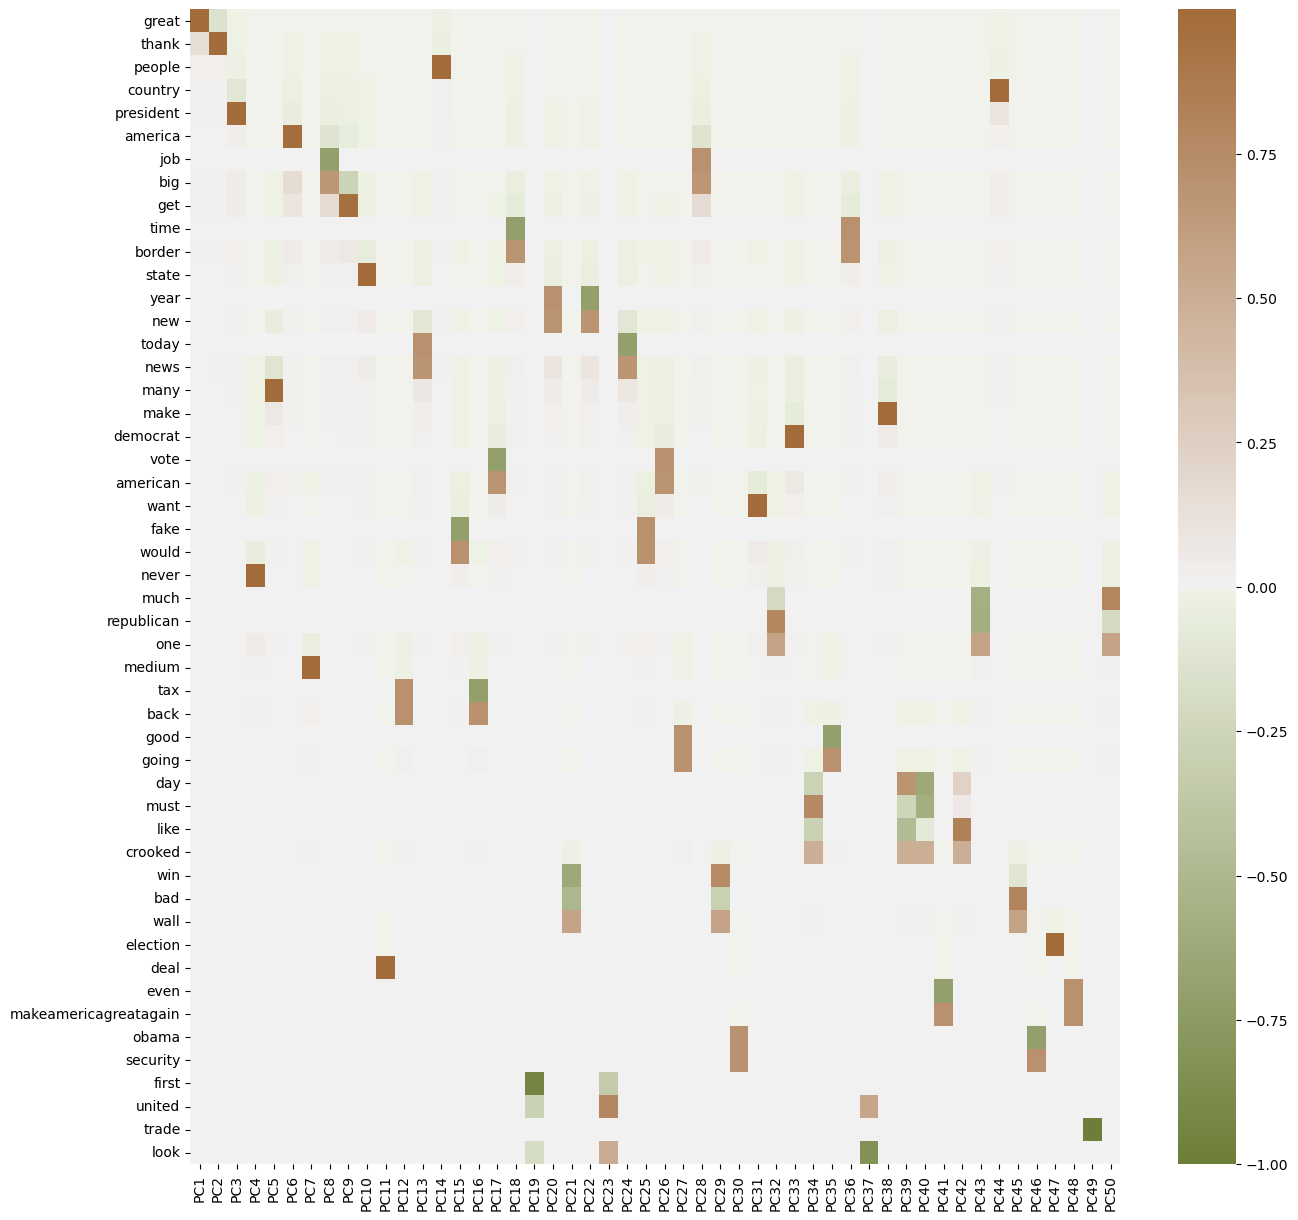

In [41]:
### BEGIN ANSWER
pcalabel = []
for i in range(1,51):
    pcalabel.append('PC'+str(i))

plt.figure(figsize=(15,15))
cmap = sns.diverging_palette(100, 400, as_cmap=True)
sns.heatmap(principal_components, cmap=cmap, yticklabels = top_50_words_list, xticklabels = pcalabel)
plt.show()
### END ANSWER

### PCA Compare
We can determine how many words and how many components are needed to do a good visualization. Plot PC1 and PC2 in a 2D plot.

This is a scatter plot of the values of the components, but with arrows indicating some of the prominent terms as indicated by their loading factors. The values of the loading factors are used to determine the length and direction of these arrows and as such they serve as a way of expressing direction. That is, tweets which use these terms will be moved along the length of those arrows. Shown are the most important parameters.

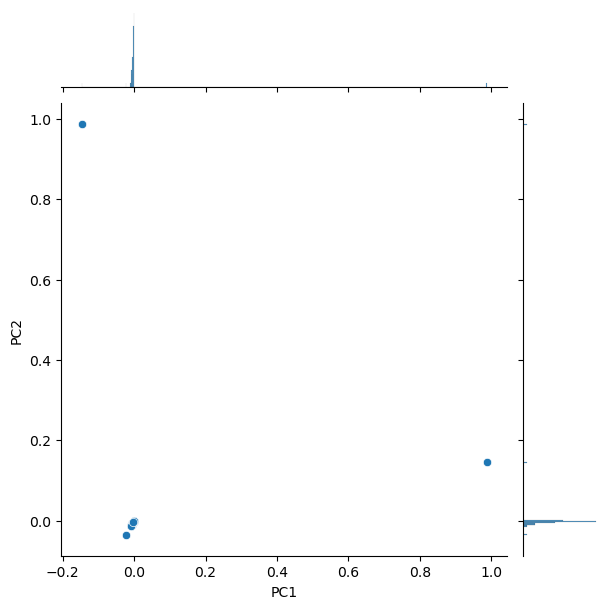

In [44]:
### BEGIN ANSWER
ax = sns.jointplot(x = pca.components_[0], y = pca.components_[1])
ax.set_axis_labels('PC1', 'PC2')
### END ANSWER

## Twitter Engagement

In this problem, we'll explore which words led to a greater average number of retweets. For example, at the time of this writing, Donald Trump has two tweets that contain the word 'oakland' (tweets 932570628451954688 and 1016609920031117312) with 36757 and 10286 retweets respectively, for an average of 23,521.5.


Your `top_20` table should have this format:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>retweet_count</th>
    </tr>
    <tr>
      <th>word</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>jong</th>
      <td>40675.666667</td>
    </tr>
    <tr>
      <th>try</th>
      <td>33937.800000</td>
    </tr>
    <tr>
      <th>kim</th>
      <td>32849.595745</td>
    </tr>
    <tr>
      <th>un</th>
      <td>32741.731707</td>
    </tr>
    <tr>
      <th>maybe</th>
      <td>30473.192308</td>
    </tr>
  </tbody>
</table>

### Top Tweets
Find the top 20 most retweeted words. Include only words that appear in at least 25 tweets. As usual, try to do this without any for loops. You can string together ~5-7 pandas commands and get everything done on one line.

In [45]:
#top_20 = ...
### BEGIN ANSWER
top_20 = (tidy_format.groupby('word').filter(lambda x: len(x) >= 25).join(df_trump['retweet_count']).groupby('word').agg({'retweet_count': 'mean'}).sort_values('retweet_count', ascending=False).head(20))

t = tidy_format.groupby('word').filter(lambda x: len(x) >= 25).join(df_trump['retweet_count']).reset_index()
t = t.drop_duplicates(subset=['id', 'word'],
keep="last").groupby('word').agg({'retweet_count': 'mean'}).sort_values('retweet_count', ascending=False)
top_20 = t
top_20 = top_20.head(20)
top_20
### END ANSWER

,retweet_count
word,
jong,33916.232558
christmas,30701.909091
maybe,30145.967742
un,29609.377358
kavanaugh,29274.392857
kim,29206.096774
old,28794.926829
mccabe,28575.444444
illegally,27991.222222


### Bar Chart
Plot a bar chart of your results:

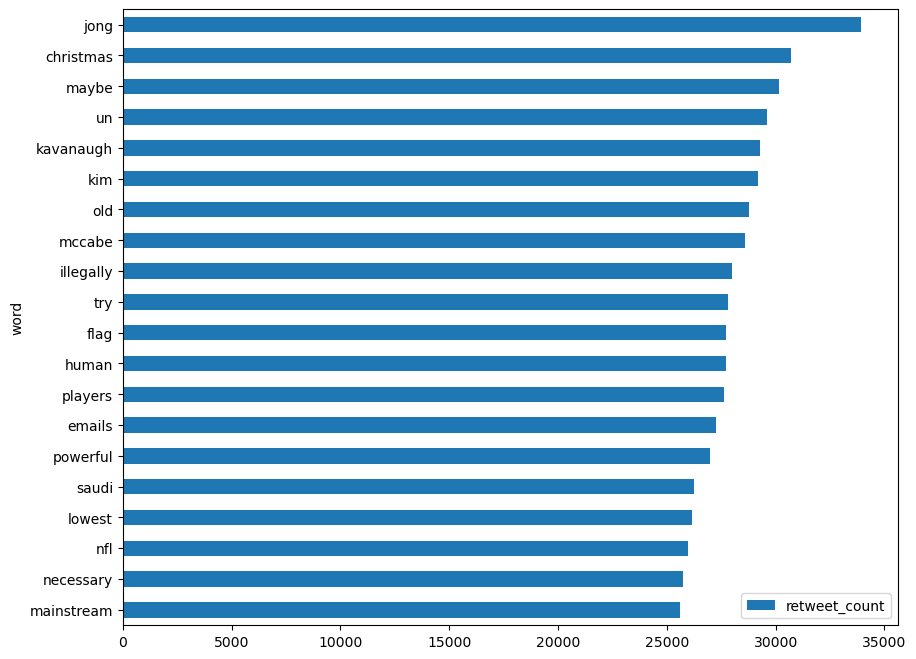

In [48]:
### BEGIN ANSWER
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)

top_20.sort_values(by='retweet_count', ascending=True).plot(kind='barh')
plt.show()
### END ANSWER